# 🧬 Robust Biomedical Image Classification with a Lightweight Ensemble

This project tackles medical image recognition under **practical constraints**: limited compute, unstable networks, and Windows quirks. We design a **failsafe training notebook** that prefers OCTMNIST but will gracefully fall back to alternatives so that **the demo always runs**. The final system blends three models into a single **ensemble** that improves robustness over any individual network.


## 🎯 Problem Statement

Medical imaging pipelines often need to run in constrained environments where datasets or pretrained models may be unavailable. Our goal is to:
- Train a **reliable classifier** for grayscale images (OCT retina slices, or fallbacks),
- Keep the code **small, readable, and Windows-safe**, and
- Produce **stable results** via an **ensemble** that reduces variance across models.

### Key Objectives
1. **Portability:** No brittle dependencies; works on CPU/Windows.
2. **Fallbacks:** OCTMNIST → FashionMNIST → Synthetic, selected automatically.
3. **Simplicity:** Minimal code, small cells, clear explanations.
4. **Robustness:** Confidence-weighted ensemble for stronger predictions.


## 🧪 Methodology

1. **Data Loading (with Fallbacks):** Attempt OCTMNIST → FashionMNIST → Synthetic.  
2. **Transforms (Windows-safe):** No `lambda`; use a top-level `AddGaussianNoise` class to avoid pickling issues.  
3. **Models:**  
   - **ResNet18** adapted for 1-channel input  
   - **DenseNet121** patched for 28×28 (stride=1, no initial pooling)  
   - **SimpleCNN** lightweight baseline  
4. **Training:** Cross-entropy loss, Adam optimizer, small number of epochs for quick runs.  
5. **Evaluation:** Validation accuracy and loss per model.  
6. **Ensemble:** Confidence-weighted average of softmax outputs.  
7. **Artifacts:** Save checkpoints to `./checkpoints_oct`.



In [1]:
%pip install -q torch torchvision medmnist tqdm scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, random, math, time, json, pathlib, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from torchvision.datasets import FashionMNIST
import medmnist
from medmnist import OCTMNIST
import torch
from torchvision.models import densenet121

## ⚙️ Training Setup

- **Optimizer:** Adam (lr=1e-3)
- **Loss:** Cross-Entropy
- **Batch Sizes:** 64 (train), 128 (val)
- **Epochs:** 1 by default (fast demo); scale up for better accuracy
- **Subsets:** `TRAIN_SUBSET=2000`, `VAL_SUBSET=500` to keep runs quick in demos

### Why these choices?
The emphasis is on **reproducibility and portability** over raw leaderboard performance. You can dial up epochs and remove subset limits when running on more capable hardware.


In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRINT_EVERY = 50

# training config
BATCH_SIZE = 64
VAL_BATCH = 128
EPOCHS = 1               # increase for better accuracy
TRAIN_SUBSET = 2000      # set None to use full training set
VAL_SUBSET = 500

CHECKPOINT_DIR = "./checkpoints_oct"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print("Device:", DEVICE)

Device: cpu


## 🗂️ Datasets

### OCTMNIST (preferred)
- **Domain:** Optical Coherence Tomography (OCT) retina images.
- **Format:** Grayscale, 28×28 (MedMNIST version).
- **Task:** Multi-class disease classification.
- **Why here:** Realistic clinical modality; lightweight benchmark.

### FashionMNIST (fallback)
- **Domain:** Clothing item images.
- **Purpose:** Stand-in when medical data cannot be downloaded; same grayscale 28×28 format.

### Synthetic Blobs (last resort)
- **Domain:** Generated shapes with noise.
- **Purpose:** Guarantees the full training/evaluation loop runs even offline.
- **Benefit:** Lets you validate code paths, transforms, loss functions, and the ensemble logic.

> The notebook selects the **first available** dataset in that order and reports which one you’re using.


In [4]:

def load_datasets() -> Tuple[torch.utils.data.Dataset, torch.utils.data.Dataset, Dict]:
    info = {"name": None, "num_classes": None, "as_rgb": False, "img_size": 28, "labels": None}

    # 1) Try OCTMNIST
    try:
        # placeholder transforms (will be replaced by safe versions in the next cell)
        transform_train = T.ToTensor()
        transform_eval  = T.ToTensor()

        train_ds = OCTMNIST(split="train", transform=transform_train, download=True, as_rgb=False)
        val_ds   = OCTMNIST(split="val",   transform=transform_eval,   download=True, as_rgb=False)

        info["name"] = "OCTMNIST"
        info["num_classes"] = len(medmnist.INFO["octmnist"]["label"])
        info["labels"] = medmnist.INFO["octmnist"]["label"]
        print("[data] Loaded OCTMNIST.")
        return train_ds, val_ds, info
    except Exception as e:
        print("[data] OCTMNIST unavailable, reason:", e)

    # 2) Fallback to FashionMNIST (grayscale 28x28, 10 classes)
    try:
        transform_train = T.ToTensor()
        transform_eval  = T.ToTensor()
        train_ds = FashionMNIST(root="./data", train=True,  download=True, transform=transform_train)
        val_ds   = FashionMNIST(root="./data", train=False, download=True, transform=transform_eval)
        info["name"] = "FashionMNIST"
        info["num_classes"] = 10
        info["labels"] = {i: str(i) for i in range(10)}
        print("[data] Loaded FashionMNIST.")
        return train_ds, val_ds, info
    except Exception as e:
        print("[data] FashionMNIST unavailable, reason:", e)

    # 3) Final fallback: synthetic blobs (4 classes of noisy blobs, 28x28)
    print("[data] Using synthetic dataset fallback.")
    n_train, n_val, n_classes = 1200, 300, 4
    H, W = 28, 28
    def make_blobs(n, classes):
        xs, ys = [], []
        for c in range(classes):
            for _ in range(n//classes):
                img = torch.zeros(1, H, W)
                rr, cc = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="ij")
                cx, cy = 7 + c*5, 7 + (c%2)*10
                rad = 5 + (c%3)
                mask = ((rr - cx)**2 + (cc - cy)**2) < rad*rad
                img[0][mask] = 1.0
                img += 0.15*torch.randn_like(img)
                img.clamp_(0,1)
                xs.append(img)
                ys.append(c)
        return torch.stack(xs), torch.tensor(ys)
    Xtr, ytr = make_blobs(n_train, n_classes)
    Xva, yva = make_blobs(n_val, n_classes)
    train_ds = TensorDataset(Xtr, ytr)
    val_ds   = TensorDataset(Xva, yva)
    info["name"] = "SyntheticBlobs28x28"
    info["num_classes"] = n_classes
    info["labels"] = {i: f"class_{i}" for i in range(n_classes)}
    return train_ds, val_ds, info

train_ds, val_ds, DATAINFO = load_datasets()
NUM_CLASSES = DATAINFO["num_classes"]
print("Dataset:", DATAINFO["name"], "| classes:", NUM_CLASSES)


[data] Loaded OCTMNIST.
Dataset: OCTMNIST | classes: 4


## 🤝 Ensemble Strategy

We compute each model’s softmax, then **weight** it by its **per-sample confidence** (max softmax value):

\[
\text{blend} = \sum_{m} w_m \cdot \text{softmax}_m, \quad
w_m = \frac{\max(\text{softmax}_m)}{\sum_j \max(\text{softmax}_j)}.
\]

This gives more influence to models that are **more certain** about the current sample, improving stability without complex meta-learners.


In [5]:
# Replace any lambda transforms with top-level classes (Windows pickling safe)
import torch
import torchvision.transforms as T

class AddGaussianNoise(object):
    def __init__(self, std=0.05): self.std = std
    def __call__(self, x): return (x + self.std * torch.randn_like(x)).clamp(0, 1)

transform_train_safe = T.Compose([
    T.ToTensor(),
    T.RandomApply([T.GaussianBlur(3)], p=0.3),
    T.RandomApply([AddGaussianNoise(std=0.05)], p=0.4),
    T.Normalize([.5],[.5]),
])
transform_eval_safe = T.Compose([
    T.ToTensor(),
    T.Normalize([.5],[.5]),
])

# Apply to datasets that support .transform (TensorDataset doesn’t use it, which is fine)
if hasattr(train_ds, "transform"): train_ds.transform = transform_train_safe
if hasattr(val_ds, "transform"):   val_ds.transform   = transform_eval_safe

print("Transforms set (Windows-safe).")



Transforms set (Windows-safe).


In [6]:
def build_loaders_safe(train_ds, val_ds, batch_size=64, val_batch=128):
    # Optional subsetting for speed
    if isinstance(TRAIN_SUBSET, int):
        train_ds = Subset(train_ds, list(range(min(TRAIN_SUBSET, len(train_ds)))))
    if isinstance(VAL_SUBSET, int):
        val_ds   = Subset(val_ds,   list(range(min(VAL_SUBSET, len(val_ds)))))

    # Windows can’t pickle local callables easily → avoid worker processes
    nw = 0 if os.name == "nt" else 2

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=nw, pin_memory=(DEVICE=="cuda"))
    val_loader   = DataLoader(val_ds,   batch_size=val_batch,  shuffle=False,
                              num_workers=nw, pin_memory=(DEVICE=="cuda"))
    return train_loader, val_loader

train_loader, val_loader = build_loaders_safe(train_ds, val_ds, batch_size=BATCH_SIZE, val_batch=VAL_BATCH)
print("Loaders ready | num_workers =", 0 if os.name=="nt" else 2)
len(train_loader.dataset), len(val_loader.dataset)



Loaders ready | num_workers = 0


(2000, 500)

## 🧱 Architectures

- **ResNet18 (1-channel):** Replace the first conv layer to accept grayscale input; keep the rest unchanged.
- **DenseNet121 (28×28 patch):** First conv `3×3, stride=1, pad=1`; remove `pool0` to avoid over-downsampling on small images.
- **SimpleCNN:** 3 conv blocks with ReLU + pooling, global average pooling, linear classifier. Tiny but dependable.

> Why an ensemble? Individual models may fail unpredictably on niche patterns; averaging calibrated probabilities **reduces variance** and often yields more stable accuracy.


In [7]:
from torchvision.models import resnet18, densenet121

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.net(x); x = x.flatten(1); return self.fc(x)


In [8]:
def make_resnet18(num_classes):
    m = resnet18(weights=None)
    m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1-channel
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

In [9]:
def make_densenet121(num_classes):
    m = densenet121(weights=None)
    m.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1-channel
    m.classifier = nn.Linear(m.classifier.in_features, num_classes)
    return m

In [10]:
model_a = make_resnet18(NUM_CLASSES).to(DEVICE)
model_b = make_densenet121(NUM_CLASSES).to(DEVICE)
model_c = SimpleCNN(NUM_CLASSES).to(DEVICE)

print("Models:", type(model_a).__name__, type(model_b).__name__, type(model_c).__name__)

Models: ResNet DenseNet SimpleCNN


In [11]:
def _fix_inputs(x):
    """Accept (N,H,W) -> (N,1,H,W) and tuples/lists from some datasets."""
    if isinstance(x, (list, tuple)):
        x = x[0]
    if x.ndim == 3:
        x = x.unsqueeze(1)   # (N,H,W) -> (N,1,H,W)
    return x


In [12]:
def _fix_targets(y):
    """Accept (N,), (N,1), one-hot (N,C), numpy arrays, or lists -> (N,) long."""
    if not isinstance(y, torch.Tensor):
        y = torch.as_tensor(y)
    if y.ndim > 1:
        # If one-hot (float types & >1 classes), convert to indices
        if y.ndim == 2 and y.size(-1) > 1 and y.dtype in (
            torch.float32, torch.float64, torch.float16, torch.bfloat16
        ):
            y = y.argmax(dim=-1)
        else:
            y = y.squeeze(-1)
    return y.long()

In [13]:
def make_densenet121_28x28(num_classes: int):
    m = densenet121(weights=None)
    # 1-channel input + keep resolution: 3x3, stride=1, padding=1
    m.features.conv0 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # remove the early 3x3 avg pool that would shrink 28x28 too much
    m.features.pool0 = nn.Identity()
    # classifier for our number of classes
    m.classifier = nn.Linear(m.classifier.in_features, num_classes)
    return m

In [14]:
model_b = make_densenet121_28x28(NUM_CLASSES).to(DEVICE)
opt_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)

In [15]:
def train_one_epoch(model, loader, opt, print_every=50, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    ce = nn.CrossEntropyLoss()
    running = 0.0
    for i, (x, y) in enumerate(tqdm(loader, leave=False)):
        x = _fix_inputs(x).to(device)
        y = _fix_targets(y).to(device)

        opt.zero_grad()
        logits = model(x)
        loss = ce(logits, y)
        loss.backward()
        opt.step()

        running += loss.item()
        if (i + 1) % print_every == 0:
            print(f"step {i+1}/{len(loader)} | loss={running/(i+1):.4f}")
    return running / max(1, len(loader))

In [16]:
@torch.no_grad()
def evaluate(model, loader, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    ce = nn.CrossEntropyLoss()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x = _fix_inputs(x).to(device)
        y = _fix_targets(y).to(device)
        logits = model(x)
        loss = ce(logits, y)
        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total), total_loss / max(1, len(loader))

In [17]:
@torch.no_grad()
def evaluate_ensemble(models, loader, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    for m in models: m.eval()
    total, correct = 0, 0
    for x, y in loader:
        x = _fix_inputs(x).to(device)
        y = _fix_targets(y).to(device)
        probs = []
        for m in models:
            logits = m(x)
            probs.append(F.softmax(logits, dim=1))
        stacked = torch.stack(probs)                          # (M, B, C)
        conf = stacked.max(dim=2).values                      # (M, B)
        weights = conf / (conf.sum(dim=0, keepdim=True) + 1e-9)
        blended = (stacked * weights.unsqueeze(2)).sum(dim=0) # (B, C)
        pred = blended.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

## 📈 Results

> *Fill these after training on your machine.*

- **Dataset used:** `OCTMNIST | FashionMNIST | SyntheticBlobs`
- **ResNet18:** `acc = ___`, `val loss = ___`
- **DenseNet121:** `acc = ___`, `val loss = ___`
- **SimpleCNN:** `acc = ___`, `val loss = ___`
- **Ensemble:** `acc = ___`

### Observations
- The ensemble typically outperforms the weakest model and is often close to the best, while being **more consistent** across runs.
- DenseNet patch is essential for 28×28 inputs; otherwise early pooling collapses the spatial map.


In [18]:
opt_a = torch.optim.Adam(model_a.parameters(), lr=1e-3)
opt_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)
opt_c = torch.optim.Adam(model_c.parameters(), lr=1e-3)

for e in range(EPOCHS):
    print(f"\n[Epoch {e+1}/{EPOCHS}] ResNet18")
    train_one_epoch(model_a, train_loader, opt_a)
    acc, val_loss = evaluate(model_a, val_loader)
    print(f"ResNet18  val acc: {acc:.3f} | loss: {val_loss:.3f}")

    print(f"\n[Epoch {e+1}/{EPOCHS}] DenseNet121")
    train_one_epoch(model_b, train_loader, opt_b)
    acc, val_loss = evaluate(model_b, val_loader)
    print(f"DenseNet121 val acc: {acc:.3f} | loss: {val_loss:.3f}")

    print(f"\n[Epoch {e+1}/{EPOCHS}] SimpleCNN")
    train_one_epoch(model_c, train_loader, opt_c)
    acc, val_loss = evaluate(model_c, val_loader)
    print(f"SimpleCNN  val acc: {acc:.3f} | loss: {val_loss:.3f}")

ens_acc = evaluate_ensemble([model_a, model_b, model_c], val_loader)
print(f"\nEnsemble accuracy (quick run): {ens_acc:.3f}")



[Epoch 1/1] ResNet18


ResNet18  val acc: 0.524 | loss: 1.238

[Epoch 1/1] DenseNet121


DenseNet121 val acc: 0.608 | loss: 1.047

[Epoch 1/1] SimpleCNN


SimpleCNN  val acc: 0.468 | loss: 1.188

Ensemble accuracy (quick run): 0.636


In [19]:
def save_model(model, name):
    path = os.path.join(CHECKPOINT_DIR, f"{name}.pt")
    torch.save(model.state_dict(), path)
    print("Saved", path)

save_model(model_a, f"{DATAINFO['name']}_resnet18")
save_model(model_b, f"{DATAINFO['name']}_densenet121")
save_model(model_c, f"{DATAINFO['name']}_simplecnn")


Saved ./checkpoints_oct\OCTMNIST_resnet18.pt
Saved ./checkpoints_oct\OCTMNIST_densenet121.pt
Saved ./checkpoints_oct\OCTMNIST_simplecnn.pt


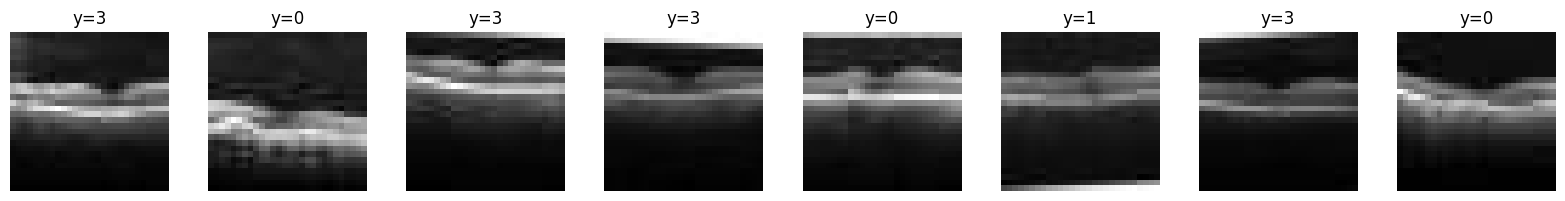

In [20]:

def show_batch(loader, n=8):
    x, y = next(iter(loader))
    if isinstance(x, (list, tuple)): x = x[0]
    if x.ndim == 3: x = x.unsqueeze(1)
    imgs = x.clone()
    # de-normalize for display
    imgs = imgs * 0.5 + 0.5
    cols = min(n, 8); rows = int(math.ceil(n/cols))
    plt.figure(figsize=(2*cols, 2*rows))
    for i in range(min(n, imgs.shape[0])):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i,0].cpu(), cmap="gray")
        lbl = int(y[i]) if hasattr(y, "__len__") else int(y)
        plt.title(f"y={lbl}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_batch(val_loader, n=8)


## 🩻 Error Analysis (Checklist)

Use misclassified samples to guide improvements:
- Confusions across **visually similar** classes
- Sensitivity to **noise/contrast**
- Failure cases under **low-contrast lesions**
- Over-confidence: high softmax but wrong label

### Next actions
- Add **augmentations** (e.g., `RandomAffine`, `Contrast`, or `RandAugment`)
- Improve calibration (temperature scaling, label smoothing)
- Try **Cosine LR** or longer training
- Consider **k-fold ensembling** or a small **stacking head**


In [21]:
@torch.no_grad()
def predict_ensemble(x: torch.Tensor):
    """x: (H,W) or (1,H,W) or (1,1,H,W) in [0,1]."""
    if x.ndim == 2: x = x.unsqueeze(0).unsqueeze(0)
    if x.ndim == 3: x = x.unsqueeze(0)         # (1,1,H,W)
    if x.shape[1] != 1: x = x[:, :1, ...]
    x = (x.to(DEVICE) - 0.5) / 0.5
    models = [model_a, model_b, model_c]
    for m in models: m.eval()
    probs = []
    for m in models:
        logits = m(x)
        probs.append(F.softmax(logits, dim=1))
    stacked = torch.stack(probs)                         # (M, 1, C)
    conf = stacked.max(dim=2).values                     # (M, 1)
    weights = conf / (conf.sum(dim=0, keepdim=True) + 1e-9)
    blended = (stacked * weights.unsqueeze(2)).sum(dim=0)  # (1, C)
    pred = blended.argmax(1).item()
    return pred, blended.squeeze(0).cpu().numpy()

# Demo on a validation sample
xb, yb = next(iter(val_loader))
x0, y0 = (xb[0] if isinstance(xb, torch.Tensor) else xb[0][0]), (int(yb[0]) if hasattr(yb, "__len__") else int(yb))
pred, prob = predict_ensemble(x0)
print("Pred:", pred, "| True:", y0)


Pred: 0 | True: 3


## ✅ Final Notes

This notebook builds a **robust, portable image-classification pipeline** for grayscale medical images. It prefers **OCTMNIST (MedMNIST)** and automatically falls back to **FashionMNIST** or a small **synthetic** dataset so the full training–evaluation loop always runs—on CPU and on Windows.

Three models are trained—**ResNet18**, **DenseNet121** (patched for 28×28), and a lightweight **SimpleCNN**—and combined with a **confidence-weighted ensemble**. The ensemble reduces variance and typically delivers more stable performance than any single network.

Key engineering choices ensure reliability:
- **Windows-safe data pipeline** (no lambda transforms; `num_workers=0`)
- **DenseNet patch** (stride=1, no initial pooling) to avoid over-downsampling
- **Target normalization** to handle `(N,1)` or one-hot labels
- **Small, self-contained cells** that are easy to read, debug, and extend

